# Imports

In [1]:
%matplotlib inline

import os
import sys
from ipywidgets import interact, FloatSlider

import dynaphos
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from IPython.display import clear_output

import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import math

from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos import cortex_models

sys.path.append(os.path.abspath(os.path.join('..')))

from utils import resize

# Circle Dummy Data

In [2]:
def generate_circle_image(shape=(128, 128), diameter=32, center=None):
    """ Generate a circle image.
    Args:
        shape (tuple): shape of the image. Either (height, width), (channels, height, width) or (batch_size, channels, height, width).
        diameter (int): diameter of the circle.
        center (tuple): center of the circle.

    Returns:
        torch.Tensor: circle image.    
    """
    if center is None:
        center = (shape[-2]//2, shape[-1]//2)
    elif type(center) == float:
        center = (center*shape[-2], center*shape[-1])
    elif type(center) == int:
        center = (center, center)
    elif type(center) == tuple and len(center) == 2 and type(center[0]) == float and type(center[1]) == float:
        center = (center[0]*shape[-2], center[1]*shape[-1])
    
    if len(shape) == 2:
        height, width = shape
        image = torch.zeros(height, width)
    elif len(shape) == 3:
        channels, height, width = shape
        image = torch.zeros(channels, height, width)
    elif len(shape) == 4:
        batch_size, channels, height, width = shape
        image = torch.zeros(batch_size, channels, height, width)
    
    for i in range(height):
        for j in range(width):
            if (i - center[0])**2 + (j - center[1])**2 < (diameter/2)**2:
                if len(shape) == 2:
                    image[i, j] = 1
                elif len(shape) == 3:
                    image[:, i, j] = 1
                elif len(shape) == 4:
                    image[:, :, i, j] = 1
    
    return image


def random_image_generator(shape=(1, 1, 128, 128), center_mean=None, center_std=None, size_mean=None, size_std=None):
    """ Generate a random image.
    Args:
        shape (tuple): shape of the image. Either (height, width), (channels, height, width) or (batch_size, channels, height, width).
        center_mean (float, int or tuple): mean of the center of the circle. Range: 0-1 or (0-1, 0-1).
        center_std (float or tuple): standard deviation of the center of the circle. Range: 0-1 or (0-1, 0-1).
        size_mean (float): mean of the size of the circle.
        size_std (float): standard deviation of the size of the circle.

    Returns:
        torch.Tensor: random image.    
    """
    if center_mean is None:
        center_mean = (0.5 * shape[-2], 0.5 * shape[-1])
    elif type(center_mean) == float:
        center_mean = (center_mean * shape[-2], center_mean * shape[-1])
    elif type(center_mean) == int:
        center_mean = (center_mean, center_mean)
    elif type(center_mean) == tuple and len(center_mean) == 2 and type(center_mean[0]) == float and type(center_mean[1]) == float:
        center_mean = (center_mean[0] * shape[-2], center_mean[1] * shape[-1])

    if center_std is None:
        center_std = (0 * shape[-2], 0 * shape[-1])
    elif type(center_std) == float:
        center_std = (center_std * shape[-2], center_std * shape[-1])
    elif type(center_std) == int:
        center_std = (center_std, center_std)
    elif type(center_std) == tuple and len(center_std) == 2 and type(center_std[0]) == float and type(center_std[1]) == float:
        center_std = (center_std[0] * shape[-2], center_std[1] * shape[-1])

    if size_mean is None:
        size_mean = 32
    elif type(size_mean) == float:
        size_mean = size_mean * shape[-1]

    if size_std is None:
        size_std = 0
    elif type(size_std) == float:
        size_std = size_std * shape[-1]

    if len(shape) == 4 and center_std[0] > 0.0 and center_std[1] > 0.0 and size_std > 0.0:
        batch_size, channels, height, width = shape
        images = torch.zeros(batch_size, channels, height, width)
        for i in range(batch_size):
            center = (np.random.normal(center_mean[0], center_std[0]),
                      np.random.normal(center_mean[1], center_std[1]))
            size = np.random.normal(size_mean, size_std)
            center = (int(center[0]), int(center[1]))
            size = int(size)
            images[i] = generate_circle_image(shape=(channels, height, width), diameter=size, center=center)
        return images
    else:
        center = (np.random.normal(center_mean[0], center_std[0]),
                  np.random.normal(center_mean[1], center_std[1]))
        size = np.random.normal(size_mean, size_std)
        center = (int(center[0]), int(center[1]))
        size = int(size)
        return generate_circle_image(shape=shape, diameter=size, center=center)

def circular_mask(shape):
    """ Generate a circular mask.
    Args:
        shape (tuple): shape of the mask. Either (height, width) or (channels, height, width).

    Returns:
        torch.Tensor: circular mask.    
    """
    if len(shape) == 2:
        height, width = shape
        mask = torch.zeros(height, width)
    elif len(shape) == 3:
        channels, height, width = shape
        mask = torch.zeros(channels, height, width)
    
    center = (height//2, width//2)
    for i in range(height):
        for j in range(width):
            if (i - center[0])**2 + (j - center[1])**2 < (height//2)**2:
                if len(shape) == 2:
                    mask[i, j] = 1
                elif len(shape) == 3:
                    mask[:, i, j] = 1
    
    return mask

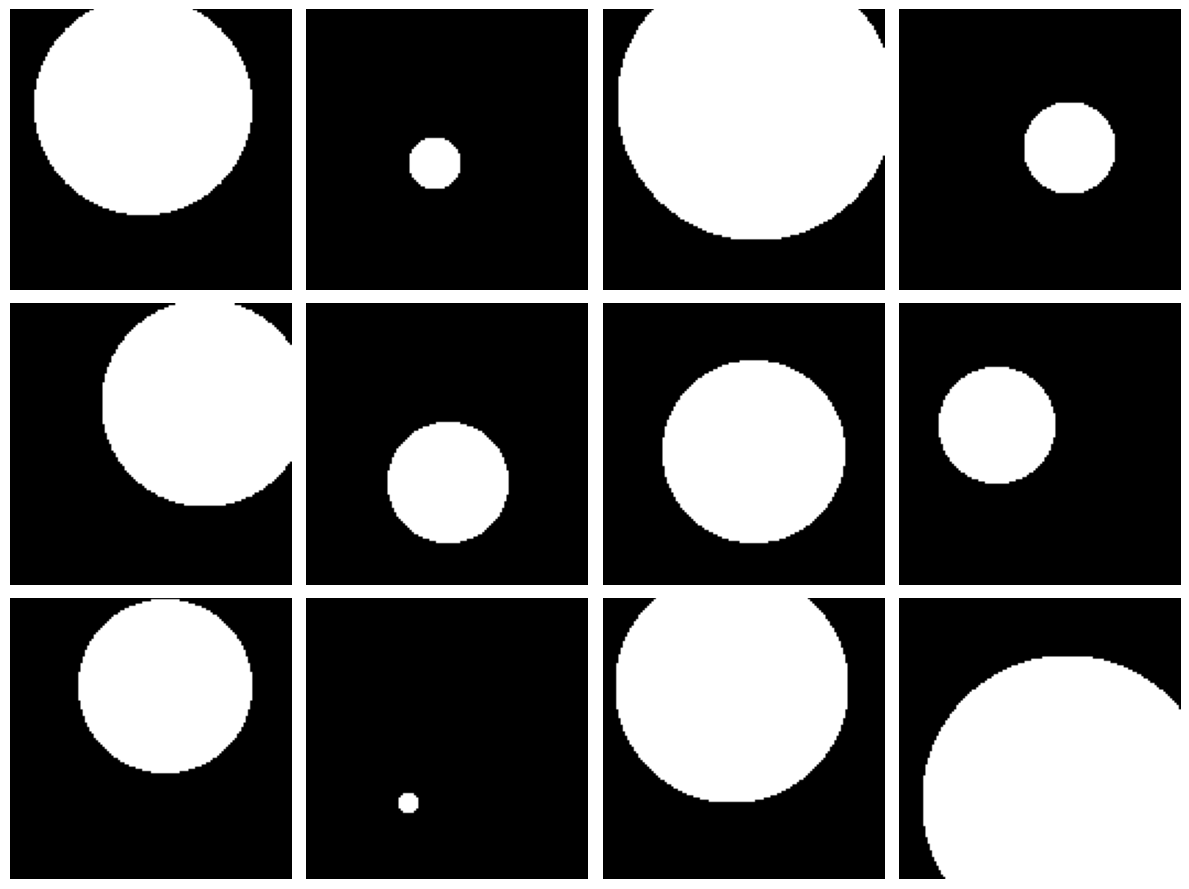

In [3]:
example_batch = random_image_generator(shape=(12, 1, 128, 128), center_mean=0.5, center_std=0.1, size_mean=0.5, size_std=0.3)
# example_batch = random_image_generator(shape=(12, 1, 128, 128), center_mean=(0.5, 0.5), center_std=0, size_mean=0.5, size_std=0)

# plot
fig, ax = plt.subplots(3, 4, figsize=(12, 9))
for i in range(3):
    for j in range(4):
        ax[i, j].imshow(example_batch[i*4+j].squeeze(), cmap='gray')
        ax[i, j].axis('off')
        
plt.tight_layout()        
plt.show()

# Simulator

In [10]:
def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

cfg = load_config('../_config/exp-local/faces_boundary_supervised_phosphenes_no_decoder.yaml')
cfg['retinal_compression'] = True
cfg['data_directory'] = '../../data/face/LaPa'
cfg['base_config'] = '../_config/exp-local/params.yaml'
cfg['phosphene_map'] = '../_config/phosphene_maps/DefaultCoordinateMap_1000_phosphenes.pickle'
cfg['batch_size'] = 1
cfg['fov'] = 5
cfg['resolution'] = [256, 256]
cfg['output_scaling'] = 1.e-4
cfg['n_electrodes'] = 1024
params = dynaphos.utils.load_params(cfg['base_config'])
params['run']['batch_size'] = cfg['batch_size']

In [11]:
def get_simulator(cfg, phosphene_coords=None):
    # initialise simulator

    params = dynaphos.utils.load_params(cfg['base_config'])
    params['run']['batch_size'] = cfg['batch_size']

    if phosphene_coords is None:
        n_phosphenes = cfg['n_electrodes']
        phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

    simulator = PhospheneSimulator(params, phosphene_coords)
    return simulator

n_phosphenes = cfg['n_electrodes']
params = dynaphos.utils.load_params(cfg['base_config'])
params['batch_size'] = 4
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = get_simulator(cfg, phosphene_coords=phosphene_coords)
cfg['SPVsize'] = simulator.phosphene_maps.shape[-2:]
len(simulator.phosphene_maps)

1024

In [12]:
cfg['SPVsize'] = simulator.phosphene_maps.shape[-2:]
print(f"Phosphene map size: {cfg['SPVsize']}")
N_PHOSPHENES = simulator.num_phosphenes
print(f"Number of phosphenes: {N_PHOSPHENES}")

Phosphene map size: torch.Size([256, 256])
Number of phosphenes: 1024


In [13]:
x, y = phosphene_coords._x, phosphene_coords._y
coords = torch.Tensor(np.array([x, y]))

In [14]:
reshape_square = np.sqrt(N_PHOSPHENES)

# if the sqrt is not an integer, we need to find the closest integer that is bigger
if int(reshape_square) != reshape_square:
    reshape_square = int(reshape_square) + 1
else:
    reshape_square = int(reshape_square)
    
reshape_square

32

In [15]:
# Function to update the plot based on the slider values
def update_plot(shift_x=0.5, shift_y=0.5, circle_size=20):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Generate the circle image with the specified size
    circle_image = generate_circle_image(shape=(1, 1, 128, 128), diameter=circle_size, center=(shift_y, shift_x)).to(cfg['device'])
    
    # Update the visual input display
    ax[0].imshow(circle_image[0].permute(1,2,0).cpu().numpy(), cmap='gray')
    ax[0].set_title('Visual Input')
    ax[0].axis('off')
    
    # Update the phosphene display
    resized_image = resize(circle_image, cfg['SPVsize'])
    stimulation = simulator.sample_centers(resized_image.mean(1, keepdim=True)) * cfg['output_scaling']
    simulator.reset()
    phosphenes = simulator(stimulation).unsqueeze(1)
    
    ax[1].imshow(phosphenes.squeeze().detach().cpu().numpy(), cmap='gray')
    ax[1].set_title('Phosphenes')
    ax[1].axis('off')
    
    # Update the stimulation display
    stimulation_square = torch.zeros((reshape_square, reshape_square), device=cfg['device'])
    stimulation_square.view(-1)[:N_PHOSPHENES] = stimulation

    ax[2].imshow(stimulation_square.cpu().numpy(), cmap='gray')
    ax[2].set_title('Stimulation')
    ax[2].axis('off')

    plt.show()

# Display the interactive widgets
plot = interact(update_plot, 
         shift_x=FloatSlider(min=0., max=1., step=0.001, value=0.5, description='Shift X'), 
         shift_y=FloatSlider(min=0., max=1., step=0.001, value=0.5, description='Shift Y'),
         circle_size=FloatSlider(min=1, max=128, step=1, value=20, description='Circle Size'))

interactive(children=(FloatSlider(value=0.5, description='Shift X', max=1.0, step=0.001), FloatSlider(value=0.…

# Retinal Encoder

In [16]:
# Pruning function
def apply_pruning(model, amount):
    for module in model.modules():
        if isinstance(module, nn.Linear):
            prune.ln_structured(module, name='weight', amount=amount, n=float('-inf'), dim=1)
            prune.remove(module, 'weight')

class Retinal_Encoder(nn.Module):
    """
    Simple non-generic encoder class that receives 128x128 input and outputs 32x32 feature map as stimulation protocol
    """
    def __init__(self, in_channels=1, out_channels=1, n_electrodes=1024, out_scaling=1e-4, out_activation='relu'):
        super(Retinal_Encoder, self).__init__()
        self.output_scaling = out_scaling
        self.out_activation = {'tanh': nn.Tanh(), ## NOTE: simulator expects only positive stimulation values 
                               'sigmoid': nn.Sigmoid(),
                               'relu': nn.ReLU(),
                               'softmax':nn.Softmax(dim=1)}[out_activation]

        self.model = nn.Sequential(
            # nn.BatchNorm2d(in_channels),
            nn.Flatten(),
            nn.LayerNorm(1024),
            nn.Linear(1024, 1024),
            self.out_activation
        )
            
    def forward(self, x):
        # x = x[:, mask == 1]
        self.out = self.model(x)
        stimulation = self.out*self.output_scaling #scaling improves numerical stability
        # stimulation = torch.clamp(stimulation, min=0, max=0.0001)
        return stimulation.squeeze(-1).squeeze(-1)

mask = circular_mask((1, 32, 32)).to(cfg['device'])
retinal_encoder = Retinal_Encoder(n_electrodes=cfg['n_electrodes'], out_scaling=cfg['output_scaling'], out_activation='relu').to(cfg['device'])
torch.use_deterministic_algorithms(False)

# print(retinal_encoder)

# amount of params
print('Retinal Encoder Parameters:', sum(p.numel() for p in retinal_encoder.parameters()))

# test forward pass
random_image = random_image_generator(shape=(1, 1, 32, 32)).to(cfg['device'])

output = retinal_encoder(random_image)
print('out size:', output.shape)
output.min(), output.max()

Retinal Encoder Parameters: 1051648
out size: torch.Size([1, 1024])


(tensor(0., device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.0002, device='cuda:0', grad_fn=<MaxBackward1>))

In [17]:
apply_pruning(retinal_encoder, 0.2)

In [18]:
print('Retinal Encoder Parameters:', sum(p.numel() for p in retinal_encoder.parameters()))

Retinal Encoder Parameters: 1051648


## Small round of Training

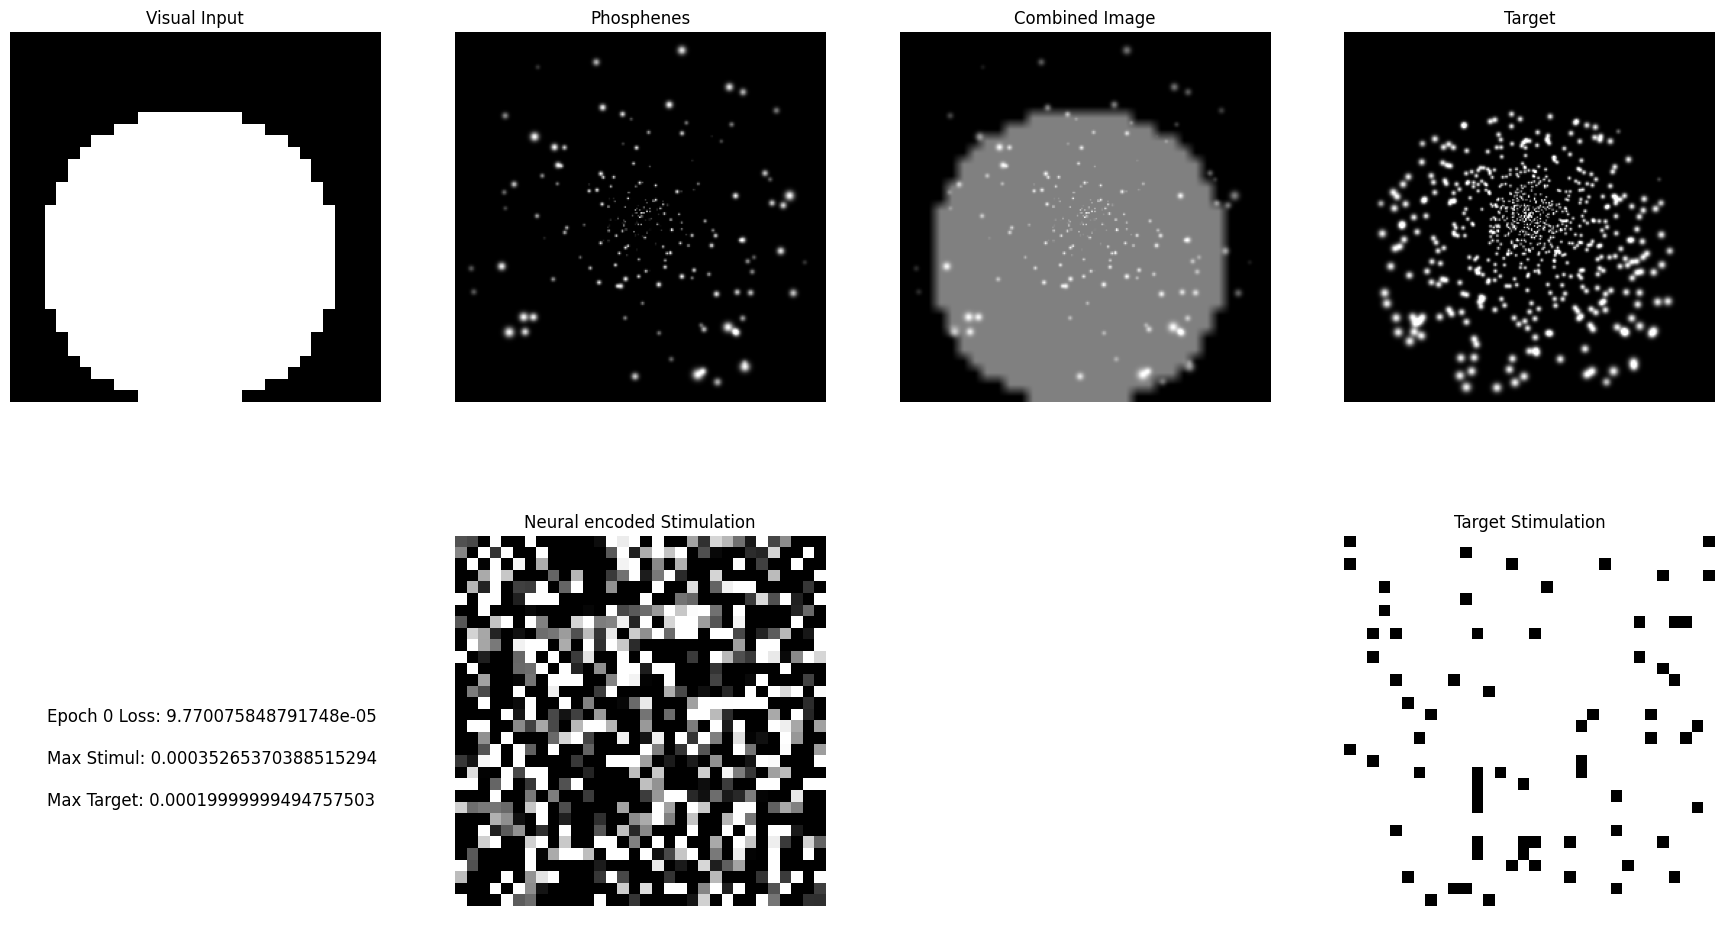

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 4.00 GiB total capacity; 2.61 GiB already allocated; 0 bytes free; 3.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
cfg['batch_size'] = 2

# Initialize the retinal encoder
cfg['output_scaling'] = 0.0002
retinal_encoder = Retinal_Encoder(out_activation='relu', n_electrodes=cfg['n_electrodes'], out_scaling=cfg['output_scaling'])
retinal_encoder.to(cfg['device'])

phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)
simulator = get_simulator(cfg, phosphene_coords)

# Define loss function
loss_fn = nn.L1Loss()
# loss_fn = nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(retinal_encoder.parameters(), lr=0.0009)

# Set deterministic algorithms off
torch.use_deterministic_algorithms(False)

mask = circular_mask((1, 32, 32)).to(cfg['device'])

for i in range(800):
    # Generate random image and make non differentiable
    random_image = random_image_generator(shape=(cfg['batch_size'], 1, 32, 32), center_std=0.2, size_mean=0.5, size_std=0.5).to(cfg['device'])*mask

    # Forward pass
    stimulation = retinal_encoder(random_image)
    simulator.reset()
    phosphenes = simulator(stimulation)
    simulator.reset()
    phosphene_centers = simulator.sample_centers(phosphenes)
    
    
    # Define target
    resized = resize(random_image.float(), cfg['SPVsize'])
    simulator.reset()
    target = simulator.sample_centers(resized.mean(1, keepdim=True))
    simulator.reset()
    target_stimulus = simulator.sample_stimulus(resized.mean(1, keepdim=True)*cfg['output_scaling'])

    # Calculate loss
    # loss = loss_fn(phosphene_centers, target)
    loss = loss_fn(stimulation, target_stimulus)

    # Zero gradients, backward pass, and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 25 == 0:
        clear_output(wait=True)

        # print(f'Epoch {i} Loss: {loss.item()}')
        # show input image and phosphenes, and combined/overlayed image, target

        fig, ax = plt.subplots(2, 4, figsize=(22, 12))
        ax[0, 0].imshow(random_image[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 0].set_title('Visual Input')

        # phosphene image
        ax[0, 1].imshow(phosphenes[0].detach().cpu().numpy(), cmap='gray')
        ax[0, 1].axis('off')
        ax[0, 1].set_title('Phosphenes')

        # combined image
        ax[0, 2].imshow(resized[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
        ax[0, 2].imshow(phosphenes[0].detach().cpu().numpy(), cmap='gray', alpha=0.5)
        ax[0, 2].axis('off')
        ax[0, 2].set_title('Combined Image')
    
        # target
        simulator.reset()
        out = simulator(target_stimulus)[0]
        ax[0, 3].imshow(out.detach().cpu().numpy(), cmap='gray')
        ax[0, 3].axis('off')
        ax[0, 3].set_title('Target')

        # 1,0 text block with training stats
        ax[1, 0].text(0.1, 0.5, f'Epoch {i} Loss: {loss.item()}', fontsize=12, ha='left')
        ax[1, 0].text(0.1, 0.4, f'Max Stimul: {stimulation.max().item()}', fontsize=12, ha='left')
        ax[1, 0].text(0.1, 0.3, f'Max Target: {target_stimulus.max().item()}', fontsize=12, ha='left')
        ax[1, 0].axis('off')
        
        # Create a square stimulation grid with a mask
        stimulation_square = torch.zeros((reshape_square, reshape_square), device=cfg['device'])
        stimulation_square.view(-1)[:N_PHOSPHENES] = stimulation[0]

        stimulation_target_square = torch.zeros((reshape_square, reshape_square), device=cfg['device'])
        stimulation_target_square.view(-1)[:N_PHOSPHENES] = target[0]

        ax[1, 1].imshow(stimulation_square.detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1.0000e-04)
        ax[1, 1].set_title('Neural encoded Stimulation')
        ax[1, 1].axis('off')

        ax[1, 2].axis('off')

        ax[1, 3].imshow(stimulation_target_square.cpu().numpy(), cmap='gray', vmin=0, vmax=1.0000e-04)
        ax[1, 3].set_title('Target Stimulation')
        ax[1, 3].axis('off')

        plt.show()

In [42]:
def update_plot(shift_x=0.0, shift_y=0.0, circle_size=20):
    fig, ax = plt.subplots(2, 3, figsize=(22, 12))

    # Generate the circle image with the specified size
    circle_image = generate_circle_image(shape=(1, 1, 32, 32), diameter=circle_size, center=(shift_y, shift_x)).to(cfg['device'])*mask
    
    # Update the visual input display
    ax[0, 0].imshow(circle_image[0].permute(1,2,0).cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[0, 0].set_title('Visual Input')
    ax[0, 0].axis('off')
    
    # Update the phosphene display
    resized_image = resize(circle_image, cfg['SPVsize'])
    
    stimulation = retinal_encoder(circle_image)
    simulator.reset()
    phosphenes = simulator(stimulation).unsqueeze(1)

    stimulation_target = simulator.sample_centers(resized_image.mean(1, keepdim=True)) * cfg['output_scaling']
    simulator.reset()
    phosphenes_target = simulator(stimulation_target).unsqueeze(1)

    # Create a square stimulation grid with a mask
    stimulation_square = stimulation.reshape(32, 32)
    stimulation_target_square = stimulation_target.reshape(32, 32)

    ax[0, 1].imshow(phosphenes.squeeze().detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[0, 1].set_title('Neural encoded Phosphenes')
    ax[0, 1].axis('off')

    ax[0, 2].imshow(phosphenes_target.squeeze().detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
    ax[0, 2].set_title('Target Phosphenes')
    ax[0, 2].axis('off')

    # 1,0 text show max values
    ax[1, 0].text(0.1, 0.5, f'Max Stimulation: {stimulation.max().item()}', fontsize=12, ha='left')
    ax[1, 0].text(0.1, 0.4, f'Max Target: {stimulation_target.max().item()}', fontsize=12, ha='left')
    ax[1, 0].axis('off')

    ax[1, 1].imshow(stimulation_square.detach().cpu().numpy(), cmap='gray', vmin=0, vmax=cfg['output_scaling'])
    max_val = stimulation.max().item()
    ax[1, 1].set_title('Neural encoded Stimulation')
    ax[1, 1].axis('off')

    ax[1, 2].imshow(stimulation_target_square.cpu().numpy(), cmap='gray', vmin=0, vmax=cfg['output_scaling'])
    # get order of magnitude
    max_val = stimulation_target.max().item()
    ax[1, 2].set_title('Target Stimulation')
    ax[1, 2].axis('off')

    plt.show()

cfg['batch_size'] = 1
simulator = get_simulator(cfg, phosphene_coords)

# Display the interactive widgets
plot = interact(update_plot, 
         shift_x=FloatSlider(min=0., max=1., step=0.001, value=0.5, description='Shift X'), 
         shift_y=FloatSlider(min=0., max=1., step=0.001, value=0.5, description='Shift Y'),
         circle_size=FloatSlider(min=1, max=32, step=1, value=16, description='Circle Size'))

interactive(children=(FloatSlider(value=0.5, description='Shift X', max=1.0, step=0.001), FloatSlider(value=0.…